In [31]:
#Importando librerías útiles
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import cv2
import scipy.misc
from matplotlib import cm
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D 
from scipy import ndimage

número de datos:  500
número de datos random:  500


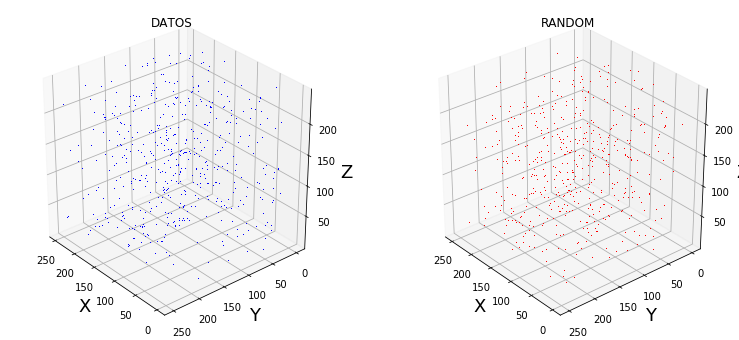

In [33]:
#Visualizando datos
fig = plt.figure(figsize=(13,6))
#subplot(columns, rows, position, projection)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(datos[:,0],datos[:,1],datos[:,2],',b')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('DATOS')
ax.view_init(30, 140)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(random[:,0],random[:,1],random[:,2],',r')
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.set_zlabel('Z',fontsize=18)
plt.title('RANDOM')
ax.view_init(30, 140)


plt.show()

In [34]:
#eliminando la 4 columna de ambos arrays de datos (estos objets ya son arrays de numpy desde el momento de importarlos con loadtxt)
data = datos.T[0:3].T
rand = random.T[0:3].T

In [35]:
#función para la construcción de la imagen del histograma
def imag(datos,titulo_figura,titulo_ejecolor,cmap):
    #creamos la figura con ese tamaño 1080px por 720px
    plt.figure(figsize=(10.8,7.2), dpi=100)

    #el Colormap (cmap) es usado para mapear datos escalares a colores
    #origin es el parametro que controla la posición donde se encuentra el origen
    # el parametro x representa los datos de la imagen, pueden ser datos escalares (matriz MXN )o imagenes con valores de RGB (MXNXL)
    # el parametro aspect controla si los pixeles son cuadrados ('equal') o son autoajustados de acuerdo a los ejes (no cuadrados 'auto')
    plt.imshow(datos, origin='lower',cmap=cmap, aspect='equal')
    #eje de color
    cax=plt.colorbar()
    #este metodo hace lineas de contorno, el primer parámetro son coordenadas de los valores de Z que es el siguiente parametro
    #el siguiente parametro son cuantas lineas de contorno se desea
    #el siguiente parametro cmap mapeo los niveles de color a grises, puede cambiarse a amarillo, u otros 
    #el siguiente parametro es el grosor de las lineas de controno, 
    plt.contour(datos, 20, cmap=plt.cm.gray, linewidths=.75)
    #titulo de los ejes
    plt.ylabel('$r_{\pi}$',fontsize = 18)
    plt.xlabel('$r_{p}$',fontsize = 18)
    #titulo de la figura
    plt.title(titulo_figura, fontsize = 16)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    #eje de color
    #labelpad indica cuanto espacio debe haber hacia la derecha antes de empezar el texto
    cax.set_label(titulo_ejecolor,labelpad = 5,fontsize = 18)
    plt.plot()

In [36]:
#Función de correlación SS
def estimador_SS(DDD, DDR, DRR, RRR):
    return (DDD - 3*DDR + 3*DRR - RRR)/RRR

In [37]:
#Función de correlación JB
def estimador_JB(DDD, DDR, DRR, RRR):
    return (DDD*RRR**2)/(DRR**3) - (3*DDR*RRR)/(DRR**2) + 2

In [38]:
#Funcion que calcula la distancia
def distancia(vector):
    d = np.sqrt(vector[:,0]**2 + vector[:,1]**2 + vector[:,2]**2)
    return d

In [49]:
#FUncion principal 
def calcular_histogramas3D(puntosD, puntosR, nbins, lim_inf, lim_sup):
    #suponiendo que el tamaño de los bins para las 3 dimensiones es el mismo (lim_sup - lim_nf)/nbins
    #Inicializando variables para histogramas y contadores utiles
    DDD = np.zeros((nbins,nbins,nbins))
    DDR = np.zeros((nbins,nbins,nbins))
    DRR = np.zeros((nbins,nbins,nbins))
    RRR = np.zeros((nbins,nbins,nbins))
    n = 0
    m = 1
    N = len(puntosD)
    #Ciclo para histogramas DDD Y RRR
    for (i,j) in zip(puntosD[:N-2], puntosR[:N-2]):
        n+=1
        m+=1
        #Para DDD
        L1_DDD = i - puntosD[n:N] #lista de N-2 puntos
        d1 = distancia(L1_DDD) #aqui calculo todos los posibles D1, para cada D1 debo calcular ahora D2 y D3
        L2_DDD = i - puntosD[m:] #va a ser una lista con N-2 puntos
        d2 = distancia(L2_DDD) #aqui calculo todas las distancias D2 
        L3_DDD = puntosD[n] - puntosD[m:]  #va a ser una lista con N-2 puntos
        d3 = distancia(L3_DDD) #aqui calculo todas las distancias D3
        HDDD, edges = np.histogramdd(np.array([d1,d2,d3]).T, bins=[nbins, nbins, nbins], range=[[lim_inf,lim_sup],[lim_inf,lim_sup],[lim_inf,lim_sup]])
        DDD += 2*HDDD
        #Para RRR
        L1_RRR = j - puntosR[n:N]
        s1 = distancia(L1_RRR)
        L2_RRR = j - puntosR[m:]
        s2 = distancia(L2_RRR)
        L3_RRR = puntosD[n] - puntosD[m:]
        s3 = distancia(L3_RRR)
        HRRR, edges = np.histogramdd(np.array([s1, s2, s3]).T, bins=[nbins, nbins, nbins], range=[[lim_inf,lim_sup], [lim_inf, lim_sup], [lim_inf, lim_sup]]) 
        RRR += 2*HRRR
    
    #Ciclo para histogramas DDR y DRR
    n = -1
    for (a,b) in zip(puntosD[:N-1], puntosR[:N-1]):
        n += 1
        #para DDR
        L1_DDR = a - puntosD[n:] # N puntos
        d1 = distancia(L1_DDR)
        L2_DDR = puntosD[n+1] - puntosR # N puntos
        d2 = distancia(L2_DDR)
        L3_DDR = puntosR[n:] - a #N puntos
        d3 = distancia(L3_DDR)
        HDDR, edges = np.histogramdd(np.array([d1, d2, d3]).T, bins=[nbins, nbins, nbins], range=[[lim_inf, lim_sup],[lim_inf, lim_sup], [lim_inf, lim_sup]])
        DDR += HDDR
        
        #para DRR
        L1_DRR = b - puntosR[n:]
        s1 = distancia(L1_DDR)
        L2_DRR = puntosR[n+1] - puntosD
        s2 = distancia(L2_DDR)
        L3_DRR = puntosD[n:] - a
        s3 = distancia(L3_DDR)
        HDRR, edges = np.histogramdd(np.array([s1, s2, s3]).T, bins=[nbins, nbins, nbins], range=[[lim_inf, lim_sup],[lim_inf, lim_sup], [lim_inf, lim_sup]])
        DRR += HDRR
    return DDD, DDR, DRR, RRR, edges


In [50]:
#Código principal
to = timer()
DDD, DDR, DRR, RRR, edges = calcular_histogramas3D(data, rand, 30, 0, 180)
tf = timer()

print(f'Finalizado en: {round(tf-to,2)} segundos')

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

In [ ]:
#calculando los estimadores
eps_SS_3d = estimador_SS(DDD, DRR, DRR, RRR)
eps_JB_3d = estimador_JB(DDD, DRR, DRR, RRR)

In [ ]:
#guardando histogramas 
np.savetxt('DDD_isofull.dat', DDD)
np.savetxt('DDR_isofull.dat', DDR)
np.savetxt('DRR_isofull.dat', DRR)
np.savetxt('RRR_isofull.dat', RRR)